## How Does Siri Work? Ask ACME Some Other Time

#### Jessica Morrise

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
from sklearn.cross_validation import train_test_split
import os
import MFCC
import gmmhmm

In [2]:
def random_params(n):
    trans_mat = np.vstack([np.random.dirichlet(np.ones(n),1) for i in xrange(n)])
    start_prob = np.random.dirichlet(np.ones(n),1)
    return trans_mat, np.squeeze(start_prob)

class GMMHMM(object):
    def __init__(self, A, weights, means, covars, pi):
        #Check dimensions
        self.N = A.shape[0] #number of states
        if self.N == A.shape[1]:
            self.A = A
        else:
            raise ValueError('A must be square.')
        if pi.size == self.N:
            self.pi = pi
        else:
            raise ValueError('pi.size != N')
        if weights.shape[0] == self.N:
            self.weights = weights
        else:
            raise ValueError('weights must have N rows')
        self.M = self.weights.shape[1] #number of components
        #got tired of checking
        self.K = means.shape[2]
        self.means = means
        self.covars = covars
        
        
    def _sample(self, n_sim=1):
        
        samples = np.zeros((n_sim,self.K))
        states = []
        for t in xrange(n_sim):
            if t == 0:
                x = np.argmax(np.random.multinomial(1, self.pi)) #initial state
            else:
                x = np.argmax(np.random.multinomial(1, self.A[x,:]))  
            states.append(x)
            sample_comp = np.argmax(np.random.multinomial(1, self.weights[x,:])) #component to sample from
            sample = np.random.multivariate_normal(self.means[x, sample_comp, :], self.covars[x, sample_comp, :, :])    
            samples[t,:] = sample
        
        return samples, np.array(states)

In [3]:
A_test = np.array([[.65, .35], [.15, .85]])
pi_test = np.array([.8, .2])
weights_test = np.array([[.7, .2, .1], [.1, .5, .4]])
means1 = np.array([[0., 17.], [19., -12.], [-16., 22.]])
means2 = np.array([[-5., 3.], [-12., -2.], [15., -32.]])
means_test = np.array([means1, means2])
covars1 = np.array([5*np.eye(2), 7*np.eye(2), np.eye(2)])
covars2 = np.array([10*np.eye(2), 3*np.eye(2), 4*np.eye(2)])
covars_test = np.array([covars1, covars2])

### Problem 1: Sampling from a GMMHMM

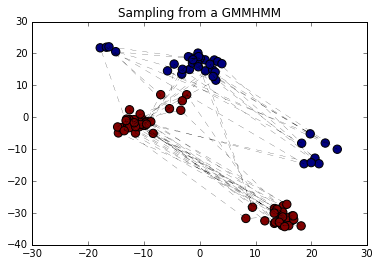

In [43]:
H = GMMHMM(A_test,weights_test,means_test,covars_test,pi_test)
samples, states = H._sample(100)
plt.plot(samples[:,0],samples[:,1], 'k--', linewidth=.2)
plt.scatter(samples[:,0],samples[:,1], c=states, s=70)
plt.title('Sampling from a GMMHMM')
plt.show()

### Problem 2: Sound samples

We load in both the dataset from last year and the dataset created by Shane and company. Both datasets contain 2-second clips of people saying the words "biology", "mathematics", "political science",, "psychology", and "statistics". The first dataset is all the same person's voice. The second contains recordings of multiple people.  

We extract and store the cepstral coefficients from both datasets.

reading biology
reading mathematics
reading polysci
reading psychology
reading statistics
reading biology
reading mathematics
reading polysci
reading psychology
reading statistics


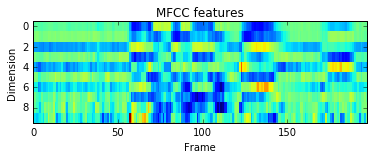

In [110]:
topics = ['biology', 'mathematics', 'polysci', 'psychology', 'statistics']

#Jeff's original samples
dir_name_1 = 'Samples'
sound_samples_1 = []

#Other samples that Shane made
dir_name_2 = 'SamplesFromShane'
sound_samples_2 = []

#Load in the first set
for tp in topics:
    print 'reading '+tp
    topic_filenames = os.listdir(dir_name_1 + '/' + tp)[1:]
    topic_sound_files = [wavfile.read(dir_name_1+'/'+tp+'/'+name)[1] for name in topic_filenames] #get rid of sampling rate
    coeffs = [MFCC.extract(f) for f in topic_sound_files]
    sound_samples_1.append(coeffs)

#Load in the second set
for tp in topics:
    print 'reading '+tp
    topic_filenames = os.listdir(dir_name_2 + '/' + tp)[1:]
    topic_sound_files = [wavfile.read(dir_name_2+'/'+tp+'/'+name)[1] for name in topic_filenames] #get rid of sampling rate
    coeffs = [MFCC.extract(f) for f in topic_sound_files]
    sound_samples_2.append(coeffs)

### Problem 3: Training the models

We train 10 models for each word, then choose the one with the highest log-likelihood. The model parameters, including the number of components and number of mixtures, is based on the lab document. Each training set size is 20 samples. sklearn's train_test_split function is used to randomly choose a training set and a test set. The function below returns a list of the best models, the training sets, and the test sets.

We train two different sets of models, one for each dataset. This way we can compare them to each other later.

In [70]:
def train_models(_samples, _topics, n_candidates=10, training_size=20):
    word_models = []
    training_sets = []
    test_sets = []

    for k in xrange(len(_topics)):
        print "training on %s"%(_topics[k])
        model_candidates = []
        log_probs = []
        train, test = train_test_split(_samples[k], train_size=training_size)
        training_sets.append(train)
        test_sets.append(test)
        for i in xrange(n_candidates):
            print 'candidate %d'%(i)
            model = gmmhmm.GMMHMM(n_components=5, n_mix=3, transmat=A, startprob= pi, cvtype='diag')
            model.covars_prior = 0.01
            model.fit(train, init_params='mc', var=0.1)
            model_candidates.append(model)
            log_probs.append(model.logprob)

        best_model = model_candidates[np.argmax(log_probs)]
        word_models.append(best_model)
        
    return word_models, training_sets, test_sets

Training on the first dataset.

In [125]:
models_1, training_1, test_1 = train_models(sound_samples_1, topics)

training on biology
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on mathematics
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on polysci
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on psychology
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on statistics
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9


And training on the second dataset.

In [126]:
models_2, training_2, test_2 = train_models(sound_samples_2, topics)

training on biology
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on mathematics
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on polysci
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on psychology
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9
training on statistics
candidate 0
candidate 1
candidate 2
candidate 3
candidate 4
candidate 5
candidate 6
candidate 7
candidate 8
candidate 9


### Problem 4: Classification

Classifying is much faster than training. Given a sound file, we score it against each model and return the index of the highest score.

In [138]:
def test_models(_models, _topics, _test_sets):
    total_tested = 0
    total_correct = 0
    accuracies = []
    #Loop through topics
    for k in xrange(len(_topics)):
        print "Actual topic: %s"%(_topics[k])
        topic_distribution = [0]*5
        
        #Loop through words in topic
        for w in _test_sets[k]:
            scores = [m.score(w) for m in _models] #score the word on each model
            best_idx = np.argmax(scores)
            topic_distribution[best_idx] += 1
        
        #Augment the totals
        total_correct += topic_distribution[k]
        total_tested += sum(topic_distribution)
        
        #Print the frequency distribution and accuracy
        acc = float(topic_distribution[k])/sum(topic_distribution)
        for j in xrange(len(_topics)):
            print "\t%s: %d"%(_topics[j],topic_distribution[j])
        print "Accuracy: %.2f percent\n"%(acc*100)
        accuracies.append(acc)
    
    total_accuracy = float(total_correct)/total_tested
    print "Overall accuracy: %.2f percent"%(total_accuracy*100)
    return accuracies, total_accuracy

The model trained on the first dataset has surprisingly good accuracy, over 90%.

In [159]:
accuracy_1, total_accuracy_1 = test_models(models_1, topics, test_1)

Actual topic: biology
	biology: 7
	mathematics: 0
	polysci: 0
	psychology: 3
	statistics: 0
Accuracy: 70.00 percent

Actual topic: mathematics
	biology: 0
	mathematics: 10
	polysci: 0
	psychology: 0
	statistics: 0
Accuracy: 100.00 percent

Actual topic: polysci
	biology: 1
	mathematics: 0
	polysci: 9
	psychology: 0
	statistics: 0
Accuracy: 90.00 percent

Actual topic: psychology
	biology: 0
	mathematics: 0
	polysci: 0
	psychology: 10
	statistics: 0
Accuracy: 100.00 percent

Actual topic: statistics
	biology: 0
	mathematics: 0
	polysci: 0
	psychology: 0
	statistics: 10
Accuracy: 100.00 percent

Overall accuracy: 92.00 percent


The model trained on the second dataset also has very good accuracy.

In [140]:
accuracy_2, total_accuracy_2 = test_models(models_2, topics, test_2)

Actual topic: biology
	biology: 23
	mathematics: 0
	polysci: 0
	psychology: 0
	statistics: 0
Accuracy: 100.00 percent

Actual topic: mathematics
	biology: 1
	mathematics: 20
	polysci: 0
	psychology: 0
	statistics: 0
Accuracy: 95.24 percent

Actual topic: polysci
	biology: 0
	mathematics: 0
	polysci: 30
	psychology: 0
	statistics: 1
Accuracy: 96.77 percent

Actual topic: psychology
	biology: 0
	mathematics: 0
	polysci: 0
	psychology: 25
	statistics: 0
Accuracy: 100.00 percent

Actual topic: statistics
	biology: 0
	mathematics: 0
	polysci: 0
	psychology: 0
	statistics: 9
Accuracy: 100.00 percent

Overall accuracy: 98.17 percent


**For fun**, we can test the two models on each other's data!

Here we classify the samples from dataset 1 under the models that were trained on dataset 2. The accuracy is, of course, much lower. We get perfect classification for political science; statistics has a classification rate of 80%; and the rest are frequently misclassified as political science. 

In [146]:
accuracy_1, total_accuracy_1 = test_models(models_2, topics, sound_samples_1)

Actual topic: biology
	biology: 10
	mathematics: 4
	polysci: 9
	psychology: 7
	statistics: 0
Accuracy: 33.33 percent

Actual topic: mathematics
	biology: 0
	mathematics: 2
	polysci: 28
	psychology: 0
	statistics: 0
Accuracy: 6.67 percent

Actual topic: polysci
	biology: 0
	mathematics: 0
	polysci: 30
	psychology: 0
	statistics: 0
Accuracy: 100.00 percent

Actual topic: psychology
	biology: 3
	mathematics: 5
	polysci: 12
	psychology: 10
	statistics: 0
Accuracy: 33.33 percent

Actual topic: statistics
	biology: 0
	mathematics: 0
	polysci: 5
	psychology: 1
	statistics: 24
Accuracy: 80.00 percent

Overall accuracy: 50.67 percent
